## Tenserflow를 이용한 다층 퍼셉트론

[1] 필요한 패키지 불러오기
- keras: 텐서플로에 제공되는 Keras 모듈
- layers: 모델 구성에 필요한 여러 가지 층 클래스를 제공하는 모듈
- optimizers: 다양한 최적화기 클래스를 제공하는 모듈
- losses: 다양한 손실 함수 클래스를 제공하는 모듈

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses

[2] 데이터 준비 함수 정의하기

In [2]:
def prepare_data():
    iris = load_iris()          # iris data set 읽기
    X = iris.data[:, 2:]        # 4개의 특징 중 꽃잎의 길이와 폭 선택
    y = iris.target              # 각 표본의 레이블
    lbl_str = iris.target_names # 'setosa', 'versicolor', 'virginica'
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.20)
    return X_tr, y_tr, X_val, y_val, lbl_str

[3] 분류 결과의 시각화 함수 정의

In [3]:
def visualize(net, X, y, multi_class, labels, class_id, colors,
               xlabel, ylabel, legend_loc='lower right'):
    # 데이터의 최소~최대 범위를 0.05 간격의 좌표값으로 나열
    x_max = np.ceil(np.max(X[:, 0])).astype(int)
    x_min = np.floor(np.min(X[:, 0])).astype(int)
    y_max = np.ceil(np.max(X[:, 1])).astype(int)
    y_min = np.floor(np.min(X[:, 1])).astype(int)
    x_lin = np.linspace(x_min, x_max, (x_max-x_min)*20+1)
    y_lin = np.linspace(y_min, y_max, (y_max-y_min)*20+1)

    # x_lin과 y_lin의 격자좌표의 x와 y 값 구하기
    x_mesh, y_mesh = np.meshgrid(x_lin, y_lin)

    # (x, y) 좌표의 배열로 만들어 신경망의 입력 구성
    X_test = np.column_stack([x_mesh.ravel(), y_mesh.ravel()])

    # 학습된 신경망으로 X_test에 대한 출력 계산
    if multi_class:
        y_hat = net.predict(X_test)
        y_hat = np.array([np.argmax(y_hat[k])
                            for k in range(len(y_hat))], dtype=int)
    else:
        y_hat = (net.predict(X_test) >= 0.5).astype(int)
        y_hat = y_hat.reshape(len(y_hat))

    # 출력할 그래프의 수평/수직 범위 설정
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # 클래스별로 산점도 그리기
    for c, i, c_name in zip(colors, labels, class_id):
        # 격자 좌표의 클래스별 산점도
        plt.scatter(X_test[y_hat == i, 0], X_test[y_hat == i, 1],
                     c = c, s = 5, alpha = 0.3, edgecolors = 'none')
        # 학습 표본의 클래스별 산점도
        plt.scatter(X[y == i, 0], X[y == i, 1],
                     c = c, s = 20, label=c_name)
    # 범례의 표시 위치 지정
    plt.legend(loc=legend_loc)
    # x축과 y축의 레이블을 지정한 후 그래프 출력
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    plt.show()

[4] 훈련 데이터 준비하기

In [4]:
nSamples = 150
nDim = 2
nClasses = 3
X_tr, y_tr, X_val, y_val, labels = prepare_data()

[5] 모델 구성

In [5]:
bp_model_tf = keras.Sequential()                                                    # 순차적으로 층이 연결된 모델을 구성하는 클래스
bp_model_tf.add(layers.InputLayer(input_shape=(nDim,)))           # 네크워크의 진입점으로 사용할 충을 구성하기 위한 클래스
bp_model_tf.add(layers.Dense(4, activation='sigmoid'))               # 은닉층 및 출력층을 위한 완전연결층을 구성하기 위한 클래스
bp_model_tf.add(layers.Dense(nClasses, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


[6] 모델의 요약 정보 출력

In [6]:
bp_model_tf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27 (108.00 B)

 Trainable params: 27 (108.00 B)

 Non-trainable params: 0 (0.00 B)

[7] 모델의 컴파일
- optimizer: 최적화기를 지정하는 스트링 또는 최적화기 인스턴스
- loss: 손실함수를 지정하는 스트링 또는 손실함수 인스턴스
- metrics: 훈련 및 테스트 과정에서 평가를 위한 척도의 리스트

In [7]:
bp_model_tf.compile(optimizer=optimizers.SGD(0.1, momentum=0.9),
                      loss=losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy'])

[8] 모델의 학습
- x, y: 입력 데이터와 레이블
- batch_size: 미니배치 크기(디폴트는 32)
- epochs: 전체 x, y에 대한 훈련을 몇 회 반복할 것인가를 지정함
- verbose: 훈련 진행 정보 출력 방식 설정
- validation_split: x, y에 제공된 데이터 중 검증용 데이터의 비율
- validation_data: 검증용 데이터 및 레이블의 튜플
- shuffle: 데이터 순서를 섞은 후 훈련을 할 것인지 지정(디폴트는 True)

In [8]:
bp_model_tf.fit(X_tr, y_tr, batch_size=15, epochs=1000, verbose=2,
                  validation_data=(X_val, y_val))

Epoch 1/1000
8/8 - 2s - 200ms/step - accuracy: 0.2750 - loss: 1.0991 - val_accuracy: 0.2333 - val_loss: 1.0898
Epoch 2/1000
8/8 - 0s - 9ms/step - accuracy: 0.3583 - loss: 1.0632 - val_accuracy: 0.2333 - val_loss: 1.0616
Epoch 3/1000
8/8 - 0s - 9ms/step - accuracy: 0.5333 - loss: 1.0061 - val_accuracy: 0.6333 - val_loss: 0.9700
Epoch 4/1000
8/8 - 0s - 9ms/step - accuracy: 0.7083 - loss: 0.9277 - val_accuracy: 0.6667 - val_loss: 0.8637
Epoch 5/1000
8/8 - 0s - 11ms/step - accuracy: 0.6833 - loss: 0.8241 - val_accuracy: 0.6333 - val_loss: 0.7756
Epoch 6/1000
8/8 - 0s - 9ms/step - accuracy: 0.6917 - loss: 0.7273 - val_accuracy: 0.7000 - val_loss: 0.6399
Epoch 7/1000
8/8 - 0s - 9ms/step - accuracy: 0.7500 - loss: 0.6381 - val_accuracy: 0.6667 - val_loss: 0.5799
Epoch 8/1000
8/8 - 0s - 9ms/step - accuracy: 0.6833 - loss: 0.5729 - val_accuracy: 0.8667 - val_loss: 0.4950
Epoch 9/1000
8/8 - 0s - 9ms/step - accuracy: 0.8917 - loss: 0.5185 - val_accuracy: 0.7333 - val_loss: 0.4752
Epoch 10/1000
8/

[9] 훈련된 모델을 이용한 분류

In [9]:
y_hat = bp_model_tf.predict(X_val, verbose=0)
y_hat_lbls = np.array([np.argmax(y_hat[k])
                         for k in range(len(X_val))])
nCorrect = (y_hat_lbls == y_val).sum()
print('Validation accuracy: {}/{} --> {:7.3f}%'.
      format(nCorrect, len(X_val), nCorrect * 100.0 / len(X_val)))

Validation accuracy: 28/30 -->  93.333%


[10] 특징 공간 결정 영역 시각화

231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


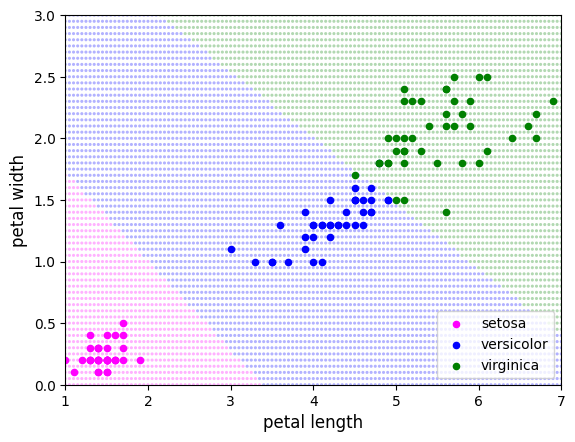

In [10]:
visualize(bp_model_tf, X_tr, y_tr,
           multi_class=True,
           class_id=labels,
           labels=[0, 1, 2],
           colors=['magenta', 'blue', 'green'],
           xlabel='petal length',
           ylabel='petal width')